In [1]:
from akd.tools.search import (
    SearxNGSearchTool,
    SearxNGSearchToolConfig,
    SearxNGSearchToolInputSchema
)
import pprint

In [2]:
SEARCH_TOOL = SearxNGSearchTool(
    config=SearxNGSearchToolConfig(
        base_url="http://localhost:8080",
        max_results=5,
        engines=["google", "arxiv", "google_scholar"],
        debug=True
    )
)

In [3]:
QUERY= "what are methods for estimating the economic impacts of landslides in Nepal"
result = await SEARCH_TOOL.arun(
    SearxNGSearchToolInputSchema(queries=[QUERY])
)

2025-06-19 12:12:23.058 | DEBUG    | akd.tools.search:_fetch_search_results_paginated:262 - Fetching page 1 for query: what are methods for estimating the economic impacts of landslides in Nepal
2025-06-19 12:12:25.385 | DEBUG    | akd.tools.search:_fetch_search_results_paginated:271 - Fetched 30 results for page 1
2025-06-19 12:12:25.487 | DEBUG    | akd.tools.search:_fetch_search_results_paginated:262 - Fetching page 2 for query: what are methods for estimating the economic impacts of landslides in Nepal
2025-06-19 12:12:26.095 | DEBUG    | akd.tools.search:_fetch_search_results_paginated:271 - Fetched 30 results for page 2
2025-06-19 12:12:26.196 | DEBUG    | akd.tools.search:_fetch_search_results_paginated:290 - Fetched 24 results across 2 pages for query: what are methods for estimating the economic impacts of landslides in Nepal
2025-06-19 12:12:26.197 | DEBUG    | akd.tools.search:arun:345 - [{'template': 'paper.html', 'url': 'http://arxiv.org/abs/1912.01233v1', 'title': 'Space-

In [4]:
print(len(result.results))
print(result.results[0].model_dump().keys())

10
dict_keys(['url', 'pdf_url', 'title', 'content', 'query', 'category', 'doi', 'published_date', 'engine', 'tags', 'extra', 'title_augmented'])


In [5]:
pprint.pprint(result.results[0].model_dump())

{'category': 'science',
 'content': 'Landslides are nearly ubiquitous phenomena and pose severe '
            'threats to people, properties, and the environment. Investigators '
            'have for long attempted to estimate landslide hazard to determine '
            'where, when, and how destructive landslides are expected to be in '
            'an area. This information is useful to design landslide '
            'mitigation strategies, and to reduce landslide risk and societal '
            'and economic losses. In the geomorphology literature, most '
            'attempts at predicting the occurrence of populations of '
            'landslides rely on the observation that landslides are the result '
            'of multiple interacting, conditioning and triggering factors. '
            'Here, we propose a novel Bayesian modelling framework for the '
            'prediction of space-time landslide occurrences of the slide type '
            'caused by weather triggers. We cons

In [ ]:
print(result.results[1].content)

… -economic effects of landslides to the particular locality. Landslide has more broader and indirect impacts, … was to assess the economic impacts of landslides. Specific objectives include: …


In [6]:
from deepeval.metrics.dag import (
    DeepAcyclicGraph,
    TaskNode,
    BinaryJudgementNode,
    NonBinaryJudgementNode,
    VerdictNode,
)
from typing import List, Optional
from deepeval.metrics.dag.nodes import BaseNode, decrement_indegree, construct_node_verbose_log
from deepeval.metrics.base_metric import BaseMetric
from deepeval.test_case import LLMTestCase, LLMTestCaseParams

from deepeval.metrics.dag import (
    DeepAcyclicGraph,
    TaskNode,
    BinaryJudgementNode,
    NonBinaryJudgementNode,
    VerdictNode,
)
import asyncio
import json


class CustomTaskNode(TaskNode):
    """
    Custom TaskNode that executes a task and generates output based on the provided
    evaluation parameters and parents.
    """

    output_label: str
    children: List[BaseNode]
    instructions:str = ""
    evaluation_params: List[LLMTestCaseParams] = None
    label: Optional[str] = None
    _verbose_logs: Optional[str] = None
    _output: Optional[str] = None
    _parents: Optional[List[BaseNode]] = None

    def __init__(
            self, 
            output_label: str,
            custom_task: callable,
            children: List[BaseNode],
            instructions: str = "",
            evaluation_params: List[LLMTestCaseParams] = None,
            label: Optional[str] = None,
            _verbose_logs: Optional[str] = None,
            _output: Optional[str] = None,
            _parents: Optional[List[BaseNode]] = None
        ):
            super().__init__(
                instructions="", 
                output_label = output_label, 
                children=children,
                evaluation_params=evaluation_params,
                label=label,
                _verbose_logs=_verbose_logs,
                _output=_output,
                _parents=_parents,
                
            )
            self.custom_task = custom_task
      

    def _execute(self, metric: BaseMetric, test_case: LLMTestCase, depth: int):
            self._depth = max(0, self._depth, depth)
            decrement_indegree(self)
            if self._indegree > 0:
                return
            
            
            params = {param_name.value: getattr(test_case, param_name.value) for param_name in self.evaluation_params}

            result = self.custom_task(**params)
            
            self._output = str(result)

            metric._verbose_steps.append(
                construct_node_verbose_log(self, self._depth)
            )


            for children in self.children:
                children._execute(
                    metric=metric, test_case=test_case, depth=self._depth + 1
                )
    
    async def _a_execute(
        self, metric: BaseMetric, test_case: LLMTestCase, depth: int
    ):
        self._depth = max(0, self._depth, depth)
        decrement_indegree(self)
        if self._indegree > 0:
            return

        params = {param_name.value: getattr(test_case, param_name.value) for param_name in self.evaluation_params}
        
        result = self.custom_task(**params)

        self._output = str(result)

        metric._verbose_steps.append(
            construct_node_verbose_log(self, self._depth)
        )
        await asyncio.gather(
            *(
                child._a_execute(
                    metric=metric, test_case=test_case, depth=self._depth + 1
                )
                for child in self.children
            )
        )

usefulness_5 = BinaryJudgementNode(
    label="Usefullness 5",
    criteria="Highlights Key Substantive Contributions: Does the agent accurately extract/highlight the key findings, arguments, or theoretical contributions from this paper's content?",
    children=[
        VerdictNode(verdict=False, score=4),
        VerdictNode(verdict=True, score=10)
    ]
)

usefulness_4 = BinaryJudgementNode(
      label="Usefullness 4",    
    criteria="Appropriate Content Scope: Is the breadth and depth of the information and arguments within this paper appropriate for its contribution to the user's query?",
    children=[
        VerdictNode(verdict=False, score=3),
        VerdictNode(verdict=True,  child=usefulness_5)
    ]
)

usefulness_3 = BinaryJudgementNode(
      label="Usefullness 3",
    criteria="Supports Research Advancement: Does the substance of this paper enable the user to advance their understanding, refine their research, or identify next steps?",
    children=[
        VerdictNode(verdict=False, score=2),
        VerdictNode(verdict=True, child=usefulness_4)
    ]
)

usefulness_2 = BinaryJudgementNode(
    label="Usefullness 2",
    criteria="Provides Novel Insights: Does the content of this paper offer information, arguments, or perspectives that are likely new or non-obvious to the user?",
    children=[
        VerdictNode(verdict=False, score=1),
        VerdictNode(verdict=True,  child=usefulness_3)
    ]
)

usefulness_1 = BinaryJudgementNode(
      label="Usefullness 1",
    criteria="Addresses Core Topic: Does the content of this paper directly address the primary research question or topic?",
    children=[
        VerdictNode(verdict=False, score=0),
        VerdictNode(verdict=True, child=usefulness_2)
    ]
)

completeness_5 = BinaryJudgementNode(
    label="Completeness 5",
    criteria="Extraction of Key Content Elements: Does the agent effectively identify/extract crucial content elements (e.g., methodology, key findings, main arguments) from this paper?",
    children=[
        VerdictNode(verdict=False, score=4),
        VerdictNode(verdict=True, score=10)
    ]
)

completeness_4 = BinaryJudgementNode(
    label="Completeness 4",
    criteria="Sufficient Internal Detail: Is the content within this specific paper presented with sufficient depth and detail for the user to understand its primary claims, methodology, and findings clearly?",
    children=[
        VerdictNode(verdict=False, score=3),
        VerdictNode(verdict=True,  child=completeness_5)
    ]
)

completeness_3 = BinaryJudgementNode(
    label="Completeness 3",
    criteria="Offers Distinct Perspective/Methodology: Does the content of this paper offer a distinct or alternative perspective/methodology relevant to the query, contributing to a broader understanding if applicable?",
    children=[
        VerdictNode(verdict=False, score=2),
        VerdictNode(verdict=True, child=completeness_4)
    ]
)

completeness_2 = BinaryJudgementNode(
    label="Completeness 2",
    criteria="Presents Significant Content: Does this paper present content that is (or appears to be) a significant, foundational, or key piece of work relevant to the query?",
    children=[
        VerdictNode(verdict=False, score=1),
        VerdictNode(verdict=True,  child=completeness_3)
    ]
)

completeness_1 = BinaryJudgementNode(
    label="Completeness 1",
    criteria="Addresses Key Theme/Sub-topic: Does the content of this paper significantly address a relevant theme or sub-topic defined by the user's query?",
    children=[
        VerdictNode(verdict=False, score=0),
        VerdictNode(verdict=True,  child=completeness_2)
    ]
)

faithfulness_5 = BinaryJudgementNode(
      label="Faithfulness 5",
    criteria="Preserves Content Nuance: Does the agent's representation of this paper's content avoid oversimplification that loses critical nuances, caveats, or limitations mentioned in the source?",
    children=[
        VerdictNode(verdict=False, score=4),
        VerdictNode(verdict=True, score=10)
    ]
)

faithfulness_4 = BinaryJudgementNode(
    label="Faithfulness 4",
    criteria="No Hallucination/Fabrication of Content: Is all information asserted by the agent about this paper's content actually present in the source document?",
    children=[
        VerdictNode(verdict=False, score=3),
        VerdictNode(verdict=True, child=faithfulness_5)
    ]
)

faithfulness_3 = BinaryJudgementNode(
    label="Faithfulness 3",
    criteria="Correct Attribution of Content: Are specific claims, findings, or data points from this paper's content clearly and correctly attributed?",
    children=[
        VerdictNode(verdict=False, score=2),
        VerdictNode(verdict=True, child=faithfulness_4)
    ]
)

faithfulness_2 = BinaryJudgementNode(
    label="Faithfulness 2",
    criteria="No Misleading Content Snippets: Are extracted textual snippets or paraphrased content from this paper presented in a way that preserves their original meaning and context?",
    children=[
        VerdictNode(verdict=False, score=1),
        VerdictNode(verdict=True, child=faithfulness_3)
    ]
)

faithfulness_1 = BinaryJudgementNode(
    label="Faithfulness 1",
    criteria="Accurate Representation of Main Points: If summaries/analyses of this paper are provided by the agent, do they accurately reflect its main points and conclusions?",
    children=[
        VerdictNode(verdict=False, score=0),
        VerdictNode(verdict=True, child=faithfulness_2)
    ]
)

accuracy_5 = BinaryJudgementNode(
    label="Accuracy 5",
    criteria="No Unsubstantiated External Inferences: Does the agent avoid introducing conclusions or interpretations about this paper not directly supported by its explicit content?",
    children=[
        VerdictNode(verdict=False, score=4),
        VerdictNode(verdict=True, score=10)
    ]
)

accuracy_4 = BinaryJudgementNode(
    label="Accuracy 4",
    criteria="Consistent Interpretation of Content: If content from this paper is used in multiple places by the agent, is its interpretation consistent?",
    children=[
        VerdictNode(verdict=False, score=3),
        VerdictNode(verdict=True, child=accuracy_5)
    ]
)

accuracy_3 = BinaryJudgementNode(
    label="Accuracy 3",
    criteria="Accuracy of Quoted/Paraphrased Content: Are direct quotations or closely paraphrased statements from this paper's content accurate and contextually sound?",
    children=[
        VerdictNode(verdict=False, score=2),
        VerdictNode(verdict=True, child=accuracy_4)
    ]
)

accuracy_2 = BinaryJudgementNode(
    label="Accuracy 2",
    criteria="Justified Content-Based Categorization: If this paper is categorized/tagged by the agent based on its substantive content, are these classifications accurate?",
    children=[
        VerdictNode(verdict=False, score=1),
        VerdictNode(verdict=True, child=accuracy_3)
    ]
)

accuracy_1 = BinaryJudgementNode(
    label="Accuracy 1",
    criteria="Accurate Thesis/Argument Representation: Does the agent accurately represent the main argument, thesis, or research questions of this paper without distortion?",
    children=[
        VerdictNode(verdict=False, score=0),
        VerdictNode(verdict=True, child=accuracy_2)
    ]
)

timeliness_4 = BinaryJudgementNode(
    label="Timeliness 4",
    criteria="Prioritization of Currently Relevant Content: Does this paper's content reflect current understanding or key ongoing discussions relevant to the query (unless historical perspective is explicitly sought for this paper)?",
    children=[
        VerdictNode(verdict=False, score=3),
        VerdictNode(verdict=True, score=10)
    ]
)

timeliness_3 = BinaryJudgementNode(
    label="Timeliness 3",
    criteria="Discernment of Outdated Content: If applicable, does the agent help discern if this paper's content, while perhaps historically relevant, might represent outdated or superseded findings?",
    children=[
        VerdictNode(verdict=False, score=2),
        VerdictNode(verdict=True, child=timeliness_4)
    ]
)

timeliness_2 = BinaryJudgementNode(
    label="Timeliness 2",
    criteria="Enduring Relevance of Foundational Content: If this paper is older, is its core content still considered seminal or essential for understanding the topic's evolution as relevant to the query?",
    children=[
        VerdictNode(verdict=False, score=1),
        VerdictNode(verdict=True, child=timeliness_3)
    ]
)

timeliness_1 = BinaryJudgementNode(
    label="Timeliness 1",
    criteria="Current Applicability of Content: Is the substance/findings of this paper current enough to be relevant, considering the field and query?",
    children=[
        VerdictNode(verdict=False, score=0),
        VerdictNode(verdict=True, child=timeliness_2)
    ]
)


extract_content_node = CustomTaskNode(
    output_label = "paper_content", 
    instructions = "",
    custom_task = lambda actual_output: actual_output["content"],
    evaluation_params=[LLMTestCaseParams.ACTUAL_OUTPUT],
    children = [usefulness_1 ,timeliness_1, faithfulness_1, completeness_1, accuracy_1],
    label="Extract content from search results",
)


dag = DeepAcyclicGraph(root_nodes=[extract_content_node]) 



In [7]:
from deepeval.metrics import DAGMetric

result_eval = DAGMetric(name="Evaluate quality of search result", dag=dag, verbose_mode=True)

test_case = LLMTestCase(input=QUERY, actual_output=result.results[0].model_dump())

result_eval.measure(test_case)
print(f"Evaluation score: {result_eval.score}, reason: {result_eval.reason}")


Output()

**************************************************

Evaluate quality of search result (DAG) Verbose Logs

**************************************************

______________________
| TaskNode | Level == 0 |
*******************************
Label: Extract content from search results

Instructions:


paper_content:
Landslides are nearly ubiquitous phenomena and pose severe threats to people, properties, and the environment. 
Investigators have for long attempted to estimate landslide hazard to determine where, when, and how destructive 
landslides are expected to be in an area. This information is useful to design landslide mitigation strategies, and
to reduce landslide risk and societal and economic losses. In the geomorphology literature, most attempts at 
predicting the occurrence of populations of landslides rely on the observation that landslides are the result of 
multiple interacting, conditioning and triggering factors. Here, we propose a novel Bayesian modelling framework 
for the prediction of space-time landslide occurrences of the slide type caused by weather triggers. We consider 
log-Gaussian cox processes, assuming that individual landslides stem from a point process described by an unknown 
intensity function. We tested our prediction framework in the Collazzone area, Umbria, Central Italy, for which a 
detailed multi-temporal landslide inventory spanning 1941-2014 is available together with lithological and bedding 
data. We tested five models of increasing complexity. Our most complex model includes fixed effects and latent 
spatio-temporal effects, thus largely fulfilling the common definition of landslide hazard in the literature. We 
quantified the spatio-temporal predictive skill of our model and found that it performed better than simpler 
alternatives. We then developed a novel classification strategy and prepared an intensity-susceptibility landslide 
map, providing more information than traditional susceptibility zonations for land planning and management. We 
expect our novel approach to lead to better projections of future landslides, and to improve our collective 
understanding of the evolution of landscapes dominated by mass-wasting processes under geophysical and weather 
triggers.
 
 
__________________________________
| BinaryJudgementNode | Level == 1 |
************************************************
Label: Usefullness 1

Criteria:
Addresses Core Topic: Does the content of this paper directly address the primary research question or topic?

Verdict: True
Reason: The content of the paper directly addresses the primary research question or topic, which is the prediction
of landslide occurrences using a novel Bayesian modelling framework. The paper focuses on estimating landslide 
hazards, understanding the factors influencing landslides, and improving prediction models, all of which are 
central to the research question. The study's application in the Collazzone area and the development of a new 
classification strategy further demonstrate its direct relevance to the core topic of landslide prediction and risk
mitigation.
 
 
__________________________________
| BinaryJudgementNode | Level == 1 |
************************************************
Label: Timeliness 1

Criteria:
Current Applicability of Content: Is the substance/findings of this paper current enough to be relevant, 
considering the field and query?

Verdict: True
Reason: The paper presents a novel Bayesian modeling framework for predicting landslide occurrences, which is a 
significant advancement in the field of geomorphology and hazard prediction. Given the increasing frequency and 
intensity of weather-related events due to climate change, the ability to predict landslides with greater accuracy 
is highly relevant. The use of a detailed multi-temporal landslide inventory and the development of an 
intensity-susceptibility map provide practical tools for land planning and management. These contributions are 
crucial for mitigating risks associated with landslides, making the findings of this paper current and applicable 
to ongoing challenges in environmental management and disaster prep

======================================================================

Evaluation score: 0.3, reason: The score is 0.3 because, despite the paper's content being relevant and timely, as indicated by the positive verdicts in the 'Usefulness 1', 'Timeliness 1', 'Accuracy 1', and 'Faithfulness 1' nodes, the traversal path reveals several critical shortcomings. The 'Accuracy 2' node received a false verdict due to misclassification, and the 'Completeness 4' node was marked false for lacking sufficient internal detail. These negative verdicts, particularly in the later stages of the DAG, significantly impacted the overall score, leading to a low evaluation of the search result's quality.


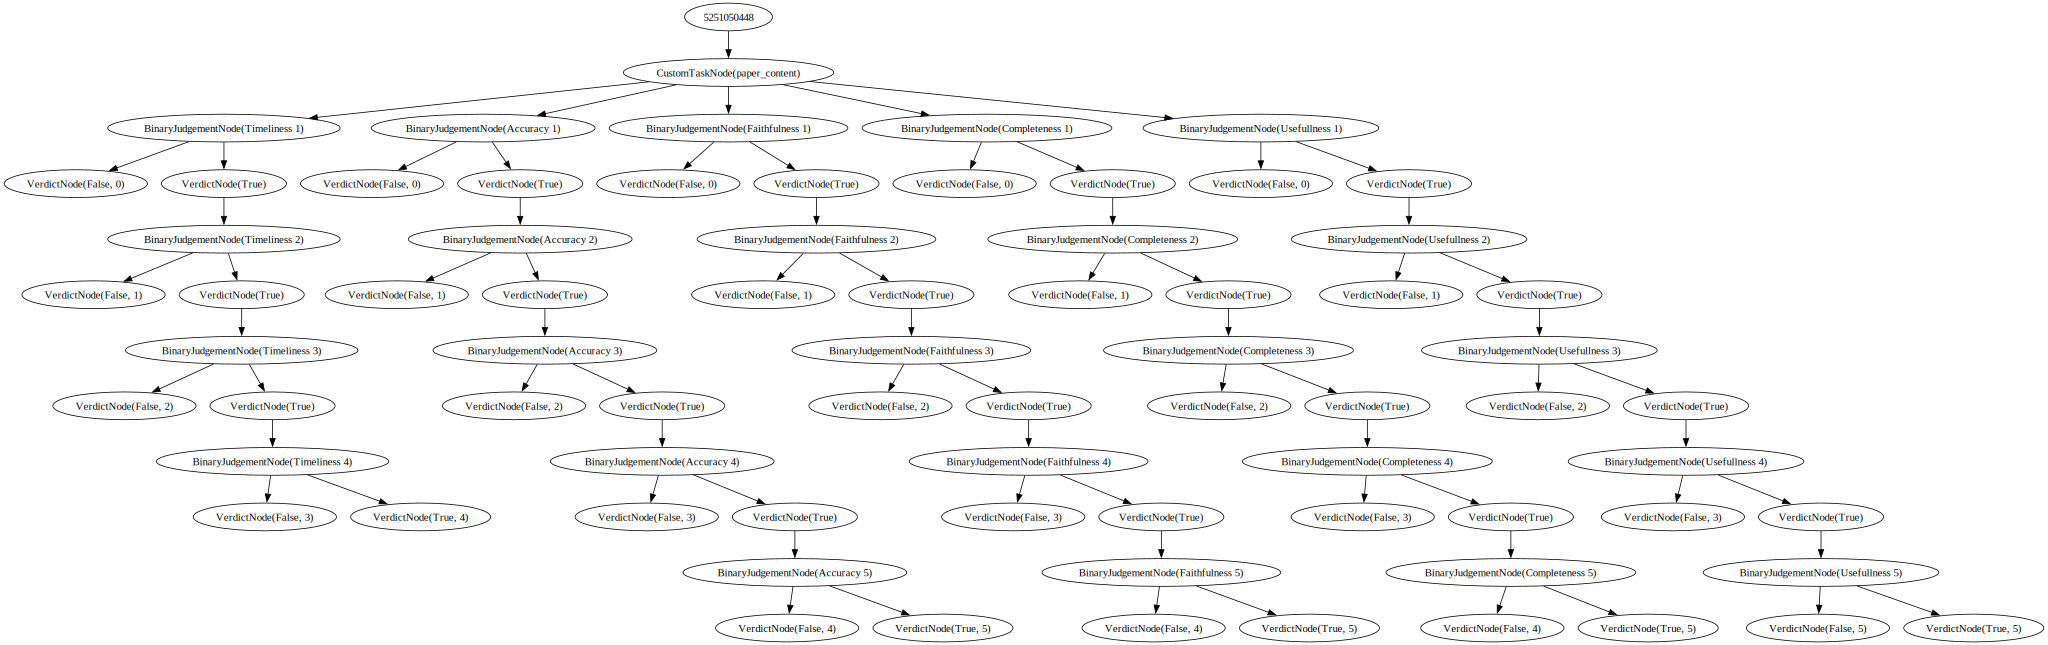

In [8]:
from graphviz import Digraph

def visualize_dag(root, get_label=lambda node: str(node)):
    """
    Visualize a DAG given a root node.
    - root: the root node of the DAG
    - get_label: function to get a label for each node (default: str(node))
    """
    dot = Digraph()
    visited = set()


    def add_edges(node):
        node_id = id(node)
        if node_id in visited:
            return

        dot.node(str(node_id), get_label(node))
        
        root_nodes = getattr(node, "root_nodes", None)
        if root_nodes:
            for root in root_nodes:
                dot.edge(str(node_id), str(id(root)))
                add_edges(root)
        
        # Handle 'child' (single node)
        child = getattr(node, "child", None)
        
        if child is not None:
            dot.edge(str(node_id), str(id(child)))
            add_edges(child)
        
        
        # Handle 'children' (list of nodes)
        children = getattr(node, "children", None)
        if children:
            for c in children:
                dot.edge(str(node_id), str(id(c)))
                add_edges(c)

    add_edges(root)
    return dot

def _get_label(node): 
    # #print(dir(node))
    # print(node)
    if isinstance(node, VerdictNode):
        return f"{node.__class__.__name__}({node.verdict}{', ' + str(node.score) if node.score is not None else ''})"
    if isinstance(node, BinaryJudgementNode):
        return f"{node.__class__.__name__}({node.label})"
    if isinstance(node, NonBinaryJudgementNode):
        return f"{node.__class__.__name__}({node.label}, {node.score})"
    if isinstance(node, TaskNode):
        return f"{node.__class__.__name__}({node.output_label})"
    
    
dot = visualize_dag(dag, get_label=_get_label)
dot  # This will render the graph inline